## ALS

In [26]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [29]:
data_path = "ml-20m"

In [30]:
movies = spark.read.load(os.path.join(data_path, 'movies.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)
links = spark.read.load(os.path.join(data_path, 'links.csv'), format='csv', header=True, inferSchema=True)
tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True, inferSchema=True)

In [31]:
# load data
movie_rating = sc.textFile(os.path.join(data_path, 'ratings.csv'))
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 2, 3.5), (1, 29, 3.5), (1, 32, 3.5)]

In [32]:
small_data, drop_data = rating_data.randomSplit([3,7], seed=99)
small_data.cache()
train, validation, test = small_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[44] at RDD at PythonRDD.scala:53

In [36]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for iters in num_iters:
        for rank in ranks:
            for reg in reg_param:
                # train ALS model
                model = ALS.train(
                    ratings=train_data,    # (userID, productID, rating) tuple
                    iterations=iters,
                    rank=rank,
                    lambda_=reg,           # regularization param
                    seed=99)
                # make prediction
                valid_data = validation_data.map(lambda p: (p[0], p[1]))
                predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
                # get the rating result
                ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
                # get the RMSE
                MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
                error = math.sqrt(MSE)
                print('{} latent factors, {} iterations and regularization = {}: validation RMSE is {}'.format(rank,iters, reg, error))
                if error < min_error:
                    min_error = error
                    best_rank = rank
                    best_regularization = reg
                    best_model = model
                    best_iterations=iters
    print('\nThe best model has {} latent factors,{} iterations and regularization = {}'.format(best_rank,best_iterations, best_regularization))
    return best_model

In [37]:
# hyper-param config
num_iterations = [5,10,15,20]
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors, 5 iterations and regularization = 0.001: validation RMSE is 1.0978310055945717
8 latent factors, 5 iterations and regularization = 0.01: validation RMSE is 0.9512585699486441
8 latent factors, 5 iterations and regularization = 0.05: validation RMSE is 0.9029716434021641
8 latent factors, 5 iterations and regularization = 0.1: validation RMSE is 0.8653390023472605
8 latent factors, 5 iterations and regularization = 0.2: validation RMSE is 0.8662126445515408
10 latent factors, 5 iterations and regularization = 0.001: validation RMSE is 1.1313538637183422
10 latent factors, 5 iterations and regularization = 0.01: validation RMSE is 0.9682460863797264
10 latent factors, 5 iterations and regularization = 0.05: validation RMSE is 0.9038032451482121
10 latent factors, 5 iterations and regularization = 0.1: validation RMSE is 0.8605333006687613
10 latent factors, 5 iterations and regularization = 0.2: validation RMSE is 0.8642836044308183
12 latent factors, 5 iterations and r

14 latent factors, 15 iterations and regularization = 0.001: validation RMSE is 1.1967255530585565
14 latent factors, 15 iterations and regularization = 0.01: validation RMSE is 1.0522152608336772
14 latent factors, 15 iterations and regularization = 0.05: validation RMSE is 0.8914124928567952
14 latent factors, 15 iterations and regularization = 0.1: validation RMSE is 0.8498169879648363
14 latent factors, 15 iterations and regularization = 0.2: validation RMSE is 0.8714190725514253
16 latent factors, 15 iterations and regularization = 0.001: validation RMSE is 1.2313659620883093
16 latent factors, 15 iterations and regularization = 0.01: validation RMSE is 1.0682795212777194
16 latent factors, 15 iterations and regularization = 0.05: validation RMSE is 0.8969806464111626
16 latent factors, 15 iterations and regularization = 0.1: validation RMSE is 0.8513657974062605
16 latent factors, 15 iterations and regularization = 0.2: validation RMSE is 0.8714444324055209
18 latent factors, 15 

In [38]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()


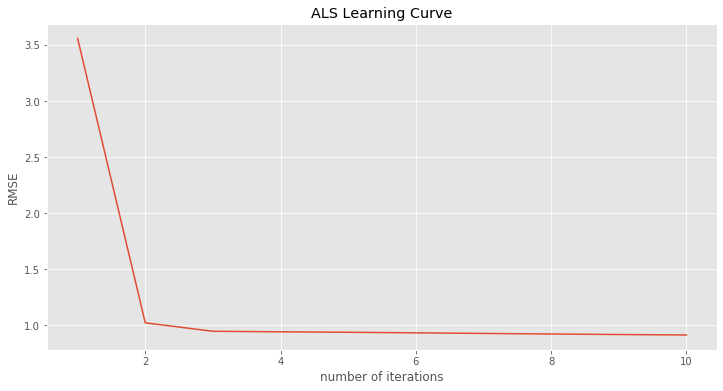

In [39]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

In [40]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8492


In [57]:
def recommend_to_user_top_n(u,n):
    for i in final_model.recommendProducts(u,n):
        movie_name=df_movies.loc[df_movies['movieId']==i[1],'title'].iloc[0]
        print(movie_name)

In [58]:
recommend_to_user_top_n(196,10)


Batman & Mr. Freeze: Subzero (1998)
Brother Minister: The Assassination of Malcolm X (1994)
Long Night's Journey Into Day (2000)
Dishonored (1931)
Little Women (1949)
Cat Came Back, The (1988)
Dylan Moran: Yeah, Yeah (2011)
Geri's Game (1997)
Mulan (2009)
For the Birds (2000)
